This Colab notebook implements a simple European option pricer using the Black–Scholes formula and visualizes payoffs and Greeks, with a Monte Carlo comparison.


## 1. Setup & Imports

In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Configure plots for inline display
%matplotlib inline

We import core libraries and enable inline plots so results display directly.

## 2. Black–Scholes Formula & Greeks Functions
Implement analytic formulas and explain why each Greek matters.


In [15]:

def bs_price(S, K, T, r, sigma, option_type='call'):
    """Compute European option price via Black–Scholes."""
    # d1 and d2 measure moneyness adjusted for drift and volatility
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        # Call = expected upside minus discounted strike cost
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        # Put = discounted strike cost minus expected downside
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Greeks measure sensitivity:
def bs_delta(S, K, T, r, sigma, option_type='call'):
    """Delta: change in option price per $1 change in underlying."""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1) if option_type=='call' else -norm.cdf(-d1)

def bs_gamma(S, K, T, r, sigma):
    """Gamma: rate of change of Delta per $1 move in underlying."""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))

def bs_vega(S, K, T, r, sigma):
    """Vega: change in price per 1% change in volatility."""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return S*norm.pdf(d1)*np.sqrt(T)

def bs_theta(S, K, T, r, sigma, option_type='call'):
    """Theta: time decay of option per year."""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    # Term1: decay from volatility
    term1 = - (S*norm.pdf(d1)*sigma)/(2*np.sqrt(T))
    # Term2: effect of interest on strike
    term2 = r*K*np.exp(-r*T)*(norm.cdf(d2) if option_type=='call' else -norm.cdf(-d2))
    return term1 - term2

def bs_rho(S, K, T, r, sigma, option_type='call'):
    """Rho: sensitivity to 1% change in interest rate."""
    d2 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T)) - sigma*np.sqrt(T)
    factor = K*T*np.exp(-r*T)
    return factor*norm.cdf(d2) if option_type=='call' else -factor*norm.cdf(-d2)

The above functions give you theoretical prices and risk measures under idealized assumptions.

## 3. Analytic Results & Visualization

In [16]:
# Sample input parameters
S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2

# Calculate pricing & Greeks
data = []
for opt in ['call','put']:
    data.append({
        'Option':opt.title(),
        'Price':bs_price(S0,K,T,r,sigma,opt),
        'Delta':bs_delta(S0,K,T,r,sigma,opt),
        'Gamma':bs_gamma(S0,K,T,r,sigma),
        'Vega':bs_vega(S0,K,T,r,sigma),
        'Theta':bs_theta(S0,K,T,r,sigma,opt),
        'Rho':bs_rho(S0,K,T,r,sigma,opt)
    })
df = pd.DataFrame(data)
df

,Option,Price,Delta,Gamma,Vega,Theta,Rho
0,Call,10.450584,0.636831,0.018762,37.524035,-6.414028,53.232482
1,Put,5.573526,-0.363169,0.018762,37.524035,-1.657880,-41.890461


*Narrative:* The table shows call and put prices alongside their sensitivities. Greeks help traders hedge specific risks.

Text(0, 0.5, 'Payoff')

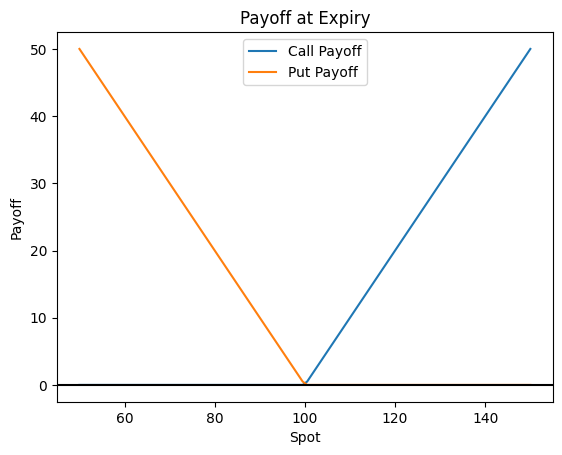

In [17]:
# Payoff diagram
t_range = np.linspace(50,150,100)
plt.plot(t_range, np.maximum(t_range-K,0), label='Call Payoff')
plt.plot(t_range, np.maximum(K-t_range,0), label='Put Payoff')
plt.axhline(0, color='black'); plt.legend(); plt.title('Payoff at Expiry')
plt.xlabel('Spot'); plt.ylabel('Payoff')

*Visual insight:* Payoff lines cross at strike, highlighting regions of profit and loss.

## 4. Monte Carlo Simulation (with Antithetic Variates)

This section simulates asset paths under Geometric Brownian Motion (GBM) to estimate European option prices by averaging discounted payoffs.

In [18]:
# MC settings
n, dt = 100_000, T
np.random.seed(2025)

# Standard MC paths
Z = np.random.standard_normal(n)
S_T = S0*np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
# Antithetic sample to reduce variance
S_T_anti = S0*np.exp((r-0.5*sigma**2)*dt - sigma*np.sqrt(dt)*Z)

payoff = lambda S: np.maximum(S-K,0)
# Combine original and antithetic payoffs
call_payoff = 0.5*(payoff(S_T)+payoff(S_T_anti))
put_payoff  = 0.5*(np.maximum(K-S_T,0)+np.maximum(K-S_T_anti,0))

disc = np.exp(-r*T)
mc_call = disc*np.mean(call_payoff)
mc_put  = disc*np.mean(put_payoff)
print(f"MC Call: {mc_call:.4f} vs BS: {bs_price(S0,K,T,r,sigma,'call'):.4f}")
print(f"MC Put : {mc_put:.4f} vs BS: {bs_price(S0,K,T,r,sigma,'put'):.4f}")

MC Call: 10.4756 vs BS: 10.4506
MC Put : 5.5896 vs BS: 5.5735


*Variance reduction:* Antithetic variates average mirrored paths, improving estimate stability.

## 5. Sensitivity Analysis
*Study price change over volatilities and maturities.*

In [20]:
sigmas = [0.1,0.2,0.3,0.4]
times  = [0.5,1.0,2.0]
rows = []
for s in sigmas:
    for t in times:
        rows.append({
            'Sigma':s,'T':t,
            'Call Price':bs_price(S0,K,t,r,s,'call'),
            'Put Price': bs_price(S0,K,t,r,s,'put')
        })
sens_df = pd.DataFrame(rows)
sens_df.pivot(index='Sigma', columns='T', values='Call Price')

T,0.5,1.0,2.0
Sigma,,,
0.1,4.192270,6.804958,11.412615
0.2,6.888729,10.450584,16.126780
0.3,9.634877,14.231255,21.193735
0.4,12.385029,18.022951,26.290240


*Interpretation:* Higher volatility or longer maturity increases option value. Table highlights these trends.

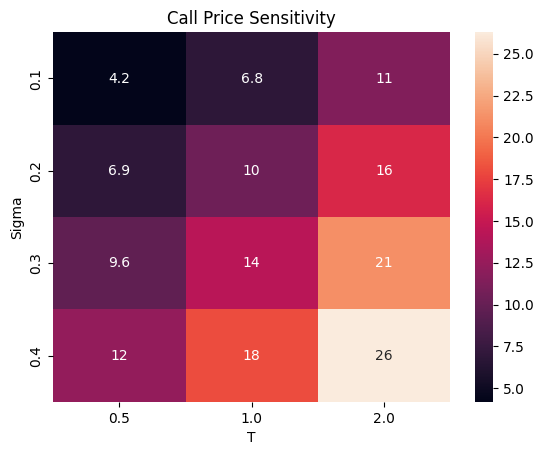

In [22]:
# Heatmap for call prices
import seaborn as sns  # only for heatmap layout
pivot = sens_df.pivot(index='Sigma',columns='T',values='Call Price')
sns.heatmap(pivot, annot=True)
plt.title('Call Price Sensitivity'); plt.show()

**Summary & Learnings:**
- Demonstrated analytic vs. simulation pricing with variance-reduction.
- Explored how Greeks change risk exposures.
- Performed sensitivity studies to guide hedging decisions.
- Optional interactive front-end can engage non-technical stakeholders.

*This project showcases both quantitative and communication skills essential for a quant role.*
